In [41]:
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# All images to be shown inside cells. 
%matplotlib inline
# To help debugging eliminate ellipses whenever reasonable.
np.set_printoptions(precision=3, edgeitems=5, linewidth=100)

In [42]:
class Lcd(object):
  """An LCD like display.
  """
  
  def __init__(self, size=8):
    """Creates a blank size x size LCD like display.
    """
    self._size = size
    self._half = size / 2  # half size of the display
    self._last = size - 1  # index of the last row or col
    self.clear()
    
  def clear(self):
    """Clears this display"""
    self._display = np.zeros((self._size, self._size), dtype=np.int32)
    
  def display(self, digit):
    """Displays the given digit on the display.
    
    Args:
      digit: number
        the number to be shown on the display
    Returns:
      LCD this LCD display
    """
    self.clear()
    try:
      getattr(self, "_%s" % str(digit))()
      return self
    except AttributeError as e:
      raise NotImplementedError("Unable to render %s" % str(digit))
    
  def copyTo(self, mat, x, y):
    mat.fill(0)
    mat[x : x + self._size, y : y + self._size] = self._display
    return mat

  def _hx3(self):
    self._display[0, :] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    
  def _0(self):
    self._display[0, :] = 1
    self._display[self._last, :] = 1
    self._display[:, 0] = 1
    self._display[:, self._last] = 1
    
  def _1(self):
    self._display[:, self._last] = 1
    
  def _2(self):
    self._hx3()
    self._display[0 : self._half, self._last] = 1
    self._display[self._half : self._size, 0] = 1
    
  def _3(self):
    self._hx3()
    self._display[:, self._last] = 1
    
  def _4(self):
    self._display[0 : self._half, 0] = 1
    self._display[self._half, :] = 1
    self._display[:, self._last] = 1

  def _5(self):
    self._hx3()
    self._display[0 : self._half, 0] = 1
    self._display[self._half : self._size, self._last] = 1    
    
  def _6(self):
    self._display[:, 0] = 1
    self._display[self._half, :] = 1
    self._display[self._last, :] = 1
    self._display[self._half : self._size, self._last] = 1
    
  def _7(self):
    self._display[0, :] = 1
    self._display[:, self._last] = 1
    
  def _8(self):
    self._0()
    self._display[self._half, :] = 1
    
  def _9(self):
    self._7()
    self._display[self._half, :] = 1
    self._display[0 : self._half, 0] = 1
    
  def __str__(self):
    return str(self._display)

In [43]:
class DigitGen(object):
  """Base class for digit generator."""
  def __init__(self, count):
    self.count = count
    
class RndDigitGen(DigitGen):
  """Random digit generator."""
  def __init__(self, count):
    super(RndDigitGen, self).__init__(count)

  def next(self):
    return np.random.randint(0, self.count)
  
class SeqDigitGen(DigitGen):
  """Sequential digit generator."""
  def __init__(self, count):
    super(SeqDigitGen, self).__init__(count)
    self._current = 0
    
  def next(self):
    d, self._current = self._current, (self._current + 1) % self.count
    return d
  
def GenerateImages(n, s, w, digit_gen):
  """Generates n random images of size s inside w x w matrix.
  
  Args:
    n: number
      The total number of images to generate
    s: number
      The size of the LCD.
    w: number
      The width and height of the matrix holding LCDs
    digit_gen: DigitGen
      Digit generator.
  Returns:
    ([n, w, w, 1], [n, d + 1]) a pair of matrices with shapes and
    a vector indicating the kind of the shape.
  """
  if n <= 0:
    return None
  m = np.zeros((n, w, w), dtype=np.float32)
  kind = np.zeros((n, digit_gen.count))
  lcd = Lcd(s)
  for i in range(n):
    digit = digit_gen.next()
    sx = 0 if w == s else np.random.randint(0, w - s + 1)
    sy = 0 if w == s else np.random.randint(0, w - s + 1)
    lcd.display(digit).copyTo(m[i], sx, sy)
    kind[i][digit] = 1
  return (m, kind)

In [44]:
def ShowAsImages(v, pred_kind, kind_name, w):
  """Shows a binary, flat raster as an image.
  
  Args:
    v: np.array
      an array of bits.
    pred_kind: np.array
      an array of ints indicating the predicted image kind.
    kind_name: list[string]
      A list that has a string corresponding to each kind index.
    w: number
      the width and height of the image
  """
  n = len(v)
  s = np.int(np.sqrt(n))
  fig, axes = plt.subplots(s, s)
  fig.set_size_inches(2 * s, 2 * s)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  
  for i, ax in enumerate(axes.flat):
    if i >= s * s: break
    imgplot = ax.imshow(1 - v[i], cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(kind_name[np.argmax(pred_kind[i])])
  plt.show()

In [45]:
# When learning we break data into batches. 
class BatchMaker(object):
  def __init__(self, img_data, kind, batch_size):
    self.img_data_ = img_data
    self.kind_ = kind
    self.batch_size_ = batch_size
    self.row_count_ = len(img_data)
    self.index_ = 0
    
  def next(self):
    img_slice = self.img_data_[self.index_ : self.index_ + self.batch_size_]
    kind_slice = self.kind_[self.index_ : self.index_ + self.batch_size_]
    self.index_ += self.batch_size_
    if self.index_ >= self.row_count_:
      self.index_ = 0
    return (img_slice, kind_slice)

In [46]:
# The width and the height of each image.
img_size = 5

# The size of each shape.
shape_size = 5

# The total number of training examples.
example_count = 1000

# The number of digits (one more than the maximum digit).
kind_count = 10

# The names or labels for each kind:
kind_names = [str(x) for x in range(kind_count)]

In [47]:
img_data, true_kind = GenerateImages(example_count, shape_size, img_size, RndDigitGen(kind_count))

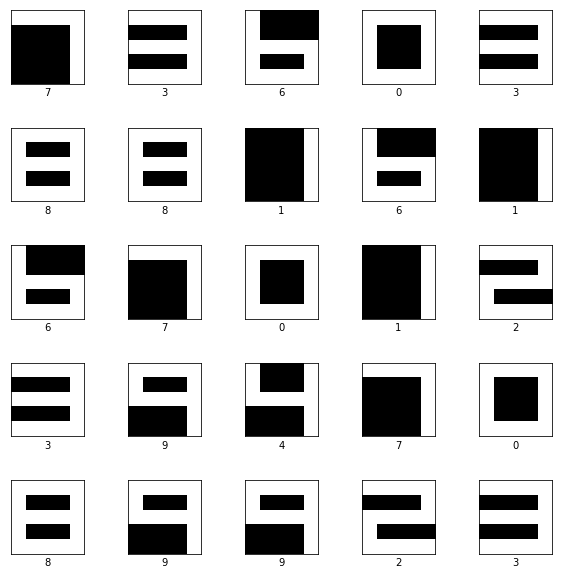

In [48]:
# Show the initial data. We have no predicated kind, so we use
# the true kind as both true and predicted kinds.
ShowAsImages(img_data[10 : 35, :], true_kind[10 : 35], kind_names, img_size)

In [49]:
# Learning parameters:

# The learning rate. Tells the optimizer how fast to follow the curve
# of the plane.
learning_rate = 0.03

# The number of images we look at a single step.
batch_size = 50

# The total number of steps we are going to run the learning step
step_count = 1000

In [50]:
# The placeholder for image bits. The first dimension is None to allow for any number
# of images. Each linear image is converted back to img_size x img_size  matrix.
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
# Reshape the 2D images to a flat vector.
x_flat = tf.reshape(x, [-1, img_size * img_size], name="x_flat")

# The placeholder for true classes. This is what is going to drive neural network
# towards the correct solution.
y_true = tf.placeholder(tf.float32, shape=[None, kind_count], name='y_true')

# Simple model. Multiply each flattened image by (img_size * img_size) x kind_count
# matrix. This produces a vector of size kind_count. Add bias to this vector and then
# use softmax cross entropy to assign a unique class to each result.
W = tf.Variable(tf.zeros([img_size * img_size, kind_count]), name="W")
b = tf.Variable(tf.zeros([kind_count]), name="b")

# Here y is the result of multiplying image data by weight matrix plus bias vector.
y_pred = tf.matmul(x_flat, W) + b
# The loss function tries to reduce mean between true labels and computed labels.
loss_op = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

# The training step uses simple gradient descent that tries to minimize loss_fn.
# It takes
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_op)

# Compute how many answers we got right.
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
# Compute accuracy as the number of correct predictions / total number of predictions.
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [51]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
batch_maker = BatchMaker(img_data, true_kind, batch_size)

Accuracy 0.305


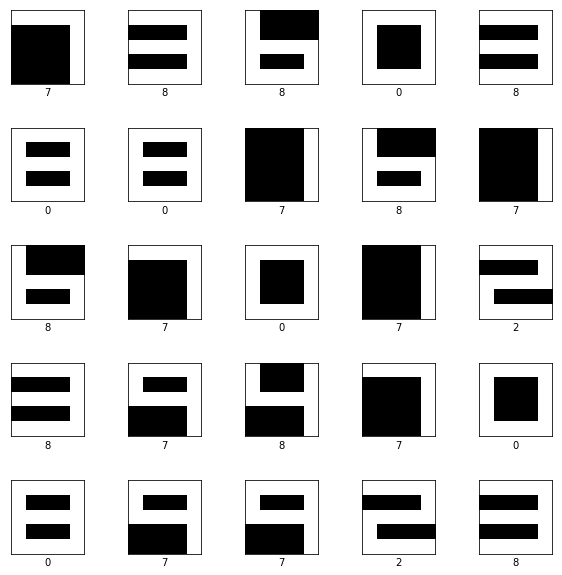

In [52]:
# Run the learning algorithm for 5 steps. Compute
# accuracy and print some predictions.
for _ in range(5):
  img_batch, label_batch = batch_maker.next()
  train_op.run(feed_dict={x: img_batch, y_true: label_batch})
  
# Compute current predictions.
pred_kind = sess.run(y_pred, feed_dict={x: img_data})
  
print "Accuracy", accuracy_op.eval(feed_dict={x: img_data, y_true: true_kind})
ShowAsImages(img_data[10 : 35, :],  pred_kind[10: 35], kind_names, img_size)

In [53]:
# Run the algorithm for the remaining step_count - 5 steps we already did.
for _ in range(step_count - 5):
  img_batch, label_batch = batch_maker.next()
  train_op.run(feed_dict={x: img_batch, y_true: label_batch})
# Compute final predictions.
pred_kind = y_pred.eval(feed_dict={x: img_data})
# Compute final weight and biases.
W_final = sess.run(W)
b_final = sess.run(b)

Accuracy 1.0


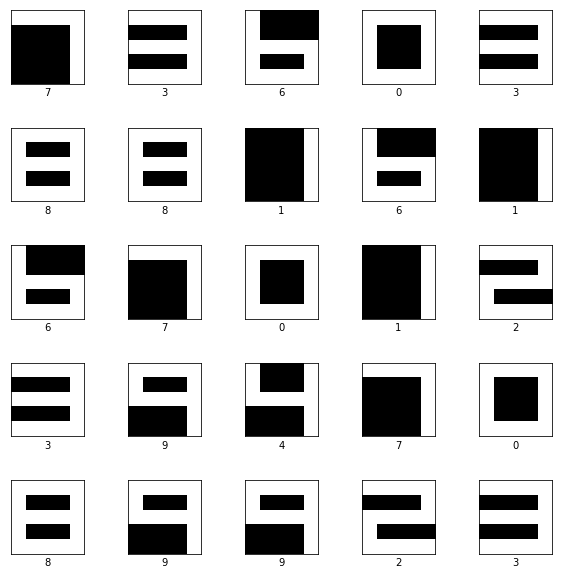

In [54]:
print "Accuracy", accuracy_op.eval(feed_dict={x: img_data, y_true: true_kind})
ShowAsImages(img_data[10 : 35, :], pred_kind[10 : 35], kind_names, img_size)

In [55]:
# Compute confusion matrix. If there are any errors, this shows us
# What confuses the model. For example, initially 3 and 8 might be
# considered very close.
cm = sess.run(tf.contrib.metrics.confusion_matrix(tf.argmax(pred_kind, 1), 
                                                  tf.argmax(true_kind, 1)))

[[104   0   0   0   0   0   0   0   0   0]
 [  0 113   0   0   0   0   0   0   0   0]
 [  0   0  83   0   0   0   0   0   0   0]
 [  0   0   0  99   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0]
 [  0   0   0   0   0  86   0   0   0   0]
 [  0   0   0   0   0   0  91   0   0   0]
 [  0   0   0   0   0   0   0 118   0   0]
 [  0   0   0   0   0   0   0   0 110   0]
 [  0   0   0   0   0   0   0   0   0  96]]


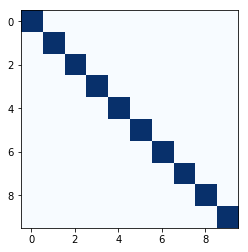

In [56]:
# Show the confusion matrix. We both show numeric values and
# heatmap representation.
print cm
cm_img = np.divide(cm.astype(np.float32), cm.sum(axis=1).reshape((kind_count, 1)), where=cm != 0)
_ = plt.imshow(cm_img, interpolation='nearest', cmap=plt.cm.Blues)

In [57]:
def Explain(W, b, s, w):
  """Produces a series of images that explain how W favors given digit.
  
  Args:
    W: np.array((s * s, 10))
      The weights array.
    b: np.array(10)
      The bias vector
    s: number
      The size of the shapes.
    w: number
      The size of the display.
  """
  col_dgt = []
  lcd = Lcd(s)
  dx = (w - s) / 2
  for digit in range(10):
    pixels = lcd.display(digit).copyTo(np.zeros((w, w), dtype=np.int32), dx, dx).reshape(1, w * w)
    v = np.matmul(pixels, W) + b
    col_dgt.append((np.argmax(v), str(digit)))
  fig, axes = plt.subplots(3, 4)
  fig.set_size_inches(9, 6)
  fig.subplots_adjust(hspace=.6, wspace=.3)
  for i, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    if i > 9:
      ax.axison=False
      continue
    # Pick the column that explains digit, reshaped as display.
    dm = W[:, col_dgt[i][0]].reshape((w, w))
    # Plot digit matrix normalized between 0 .. 1
    imgplot = ax.imshow((dm - dm.min()) / (dm.max() - dm.min()),
                        cmap=plt.cm.bwr)
    ax.set_xlabel(col_dgt[i][1])
  plt.show()

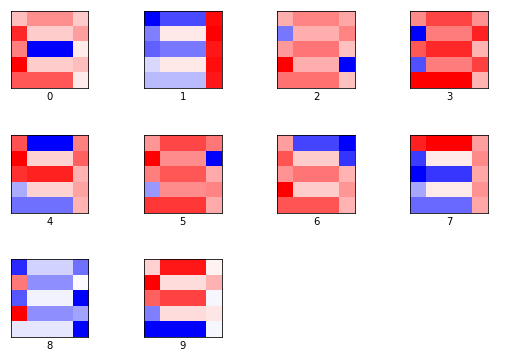

In [58]:
Explain(W_final, b_final, shape_size, img_size)

In [59]:
lcd = Lcd(shape_size)
for digit in range(kind_count):
  v = np.matmul(lcd.display(digit)._display.reshape(1, shape_size * shape_size), W_final) + b_final
  print np.argmax(v), ":", v
print
print "b :", b_final

0 : [[ 3.849 -1.094  0.089 -0.167 -2.671  0.128 -0.843  0.22   1.819 -1.331]]
1 : [[-0.08   3.864 -1.523 -0.135  0.923 -1.733 -1.483  1.369 -0.866 -0.335]]
2 : [[ 0.029 -2.709  3.39   1.726 -1.904  0.167 -0.547 -1.385  1.909 -0.676]]
3 : [[-0.635 -1.868  1.066  2.923 -1.414  1.062 -1.057 -0.793  0.989 -0.274]]
4 : [[-2.369  0.624 -1.607 -0.508  3.804 -0.549  0.142 -1.494  0.171  1.786]]
5 : [[-0.219 -3.009 -0.112  1.361 -1.137  3.09   0.202 -1.722  1.355  0.191]]
6 : [[-0.176 -2.024  0.063 -0.112  0.8    1.327  4.328 -4.366  1.877 -1.717]]
7 : [[ 0.638  1.201 -0.937  0.358 -1.244 -0.966 -3.736  4.052 -0.602  1.235]]
8 : [[ 0.657 -2.508  0.879  0.653 -1.182  0.751  0.031 -1.768  2.619 -0.132]]
9 : [[-1.705 -1.207 -1.026  0.033  1.282  0.264 -2.266  0.596  0.705  3.325]]

b : [-0.1    0.621 -0.077 -0.185  0.083 -0.124  0.077  0.2   -0.376 -0.118]


In [60]:
sess.close()